In [4]:
import pandas as pd
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from pmdarima import auto_arima  # Alternative to ARIMA model for automatic order selection
import matplotlib.pyplot as plt



In [5]:
# Load dataset
df = pd.read_excel("C:/Users/TEMP.NDOCY.000/Desktop/spaza_shop_sales_data_7_shops.xlsx")
df.columns = df.columns.str.replace(' ', '_').str.lower()  # Standardize column names
df['date'] = pd.to_datetime(df['date'], format="%Y/%m/%d %H:%M:%S")  # Adjust format if necessary
df.set_index('date', inplace=True)



In [6]:
# Remove outliers
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

df = remove_outliers(df, 'sales_units')



In [7]:
# Apply Box-Cox transformation
df['sales_units_boxcox'], lam = boxcox(df['sales_units'] + 1)  # Add 1 to handle zero values



In [15]:
# Check for stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['sales_units_boxcox'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
df = df.reset_index()
# Optionally, you can set the date column back as the index
df = df.set_index('date')
# Apply Box-Cox transformation again
df['sales_units_boxcox'], lam = boxcox(df['sales_units'] + 1)  # Add 1 to handle zero values

# Difference the data
df['sales_units_boxcox_diff'] = df['sales_units_boxcox'].diff().dropna()



ADF Statistic: -43.59363548455245
p-value: 0.0


In [16]:
print(df.index[df.index.duplicated()].unique())
df = df[~df.index.duplicated(keep='first')]


DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)


In [17]:
# Make the series stationary if necessary
# Difference the data if it is not stationary
df['sales_units_boxcox_diff'] = df['sales_units_boxcox'].diff().dropna()



In [18]:
# Fit ARIMA model on the differenced data using auto_arima for order selection
model = auto_arima(df['sales_units_boxcox'].dropna(), seasonal=False, stepwise=True, trace=True)
print(model.summary())



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=3.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16857.100, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=13520.245, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=15513.221, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=13023.366, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=12788.423, Time=0.43 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=3.33 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.64 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=2.70 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=12295.810, Time=0.62 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=12295.547, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=12293.547, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=12292.346, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=12293.5

In [19]:
# Forecast future values
forecast_steps = 365  # Forecast for one year
forecast = model.predict(n_periods=forecast_steps)




In [20]:
# Convert differenced forecast back to original scale
boxcox_forecasts_diff = pd.Series(forecast, index=pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps))
boxcox_forecasts = df['sales_units_boxcox'].iloc[-1] + boxcox_forecasts_diff.cumsum()
forecasts = inv_boxcox(boxcox_forecasts, lam)  # Inverse Box-Cox transformation



In [21]:
# Create a date range for the forecast period
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)



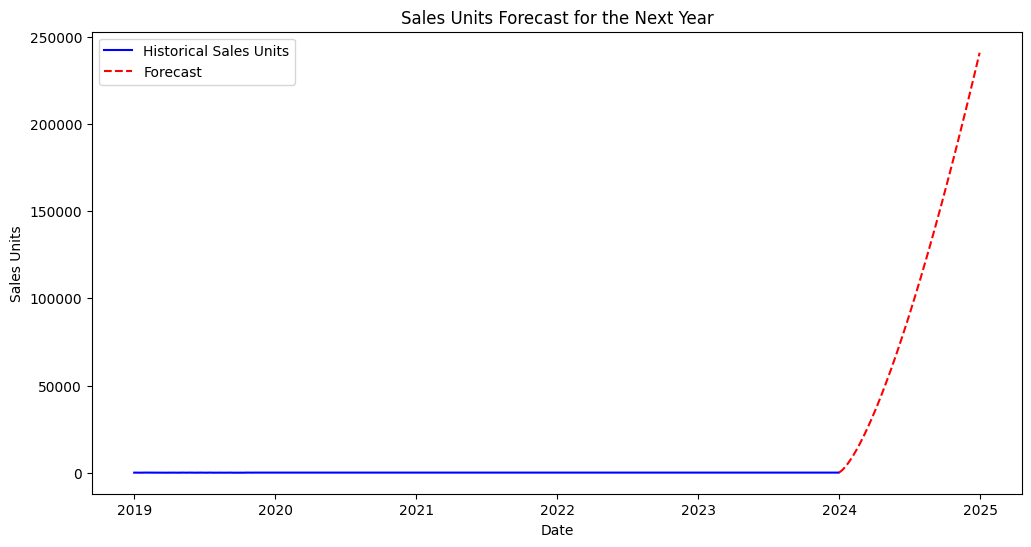

In [22]:
# Plot the forecasts
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['sales_units'], label='Historical Sales Units', color='blue')
plt.plot(forecast_dates, forecasts, label='Forecast', color='red', linestyle='--')
plt.title('Sales Units Forecast for the Next Year')
plt.xlabel('Date')
plt.ylabel('Sales Units')
plt.legend()
plt.show()